### Our objective: robustify a given neural network 
1. Identify the layer required further improvement (PENDING)
2. Evalaute effectiveness (whether robustified model truly enhance the robustness in terms of attack success rate Or PI indentification rate) (PENDING)

##### Next tasks 
1. Use fixed adversarial attack ... working
2. Record the number of valid benign/adversarial samples 
3. Record attack success rate (AST) 
4. Reconsider how to display the result 
5. Verify on robustied models  

In [8]:
'''
0. Prepare for experiments 
    Current setting: CNN (before the third layer)
'''
%matplotlib inline
import property_inference_interface, monitor
PI = property_inference_interface.PropertyInferenceInterface()
M = monitor.Monitor()

meta_params = {
    'num_of_LPs': 4,
    'size_of_train_set': 5000,
    'size_of_test_set': 100,
    'flatten': False, 
    'model_type': 'CNN',
    'adv_attack': 'i_FGSM'
}

savefig = True 
num_of_rob_train_eps = 50

PI.set_meta_params(meta_params)
PI.print_meta_params()
PI.prepare_dataset()
PI.print_dataset_shape()

num_of_LPs           : 4
size_of_train_set    : 5000
size_of_test_set     : 100
flatten              : False
model_type           : CNN
adv_attack           : i_FGSM
Train dataset
(5000, 1, 28, 28) (5000,)
Test dataset
(100, 1, 28, 28) (100,)


In [9]:
'''
0. Prepare for experiments 
'''
# PI.generate_model(num_of_epochs=15)
# PI.store_model('MNIST_CNN.pt')
PI.load_model('MNIST_CNN.pt')

print('Evaluate accurancy: original')
PI.eval_model('train', on_robustified_model=False)
PI.eval_model('test', on_robustified_model=False)

###################################################
# debug 
###################################################
# PI.generate_twisted_model('CNN', dropout_rate=0.1)
# print('Evaluate accurancy: twisted')
# PI.eval_model('train', on_robustified_model=True)
# PI.eval_model('test', on_robustified_model=True)
###################################################

Evaluate accurancy: original


//anaconda3/lib/python3.7/site-packages/torch/serialization.py:453: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
//anaconda3/lib/python3.7/site-packages/torch/serialization.py:453: SourceChangeWarning: source code of class 'torch.nn.modules.linear.Linear' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


Model ( train ) accurancy: 0.9876
Model ( test ) accurancy: 0.98


0.98

In [ ]:
'''
0. Prepare for experiments 
'''
PI.generate_LPs()
(B_detect_ratio, A_detect_ratio), (B_LPs, A_LPs), (B_LPs_score, A_LPs_score) = PI.evaluate_algorithm_on_test_set(verbose=True)

# B: Benign (normal) samples within test dataset 
# B2: Benign (normal) samples within train dataset 
# A: Adversarial samples based on benign samples within test dataset 

In [4]:
'''
4. reconsider how to display the result (PENDING)
'''
import matplotlib.pyplot as plt
import numpy as np

print(B_detect_ratio, A_detect_ratio)

BLPs, ALPs = np.array(B_LPs), np.array(A_LPs) 
print(BLPs.shape, ALPs.shape)

BLPs[BLPs=='benign'] = 1
BLPs[BLPs=='adversarial'] = 0
BLPs = BLPs.astype(np.int)
prob_BLPs = np.sum(BLPs, axis=0) / BLPs.shape[0]

ALPs[ALPs=='benign'] = 1
ALPs[ALPs=='adversarial'] = 0
ALPs = ALPs.astype(np.int)
prob_ALPs = np.sum(ALPs, axis=0) / ALPs.shape[0]

print('This indicates the portion of inputs to be judged as "benign"')
print(prob_BLPs, 'test dataset (benign)')
print(prob_ALPs, 'test dataset (adversarial)')

0.8367346938775511 1.0
(49, 4) (49, 4)
This indicates the portion of inputs to be judged as "benign"
[0.87755102 0.91836735 0.95918367 0.91836735] test dataset (benign)
[0.         0.93877551 0.         1.        ] test dataset (adversarial)


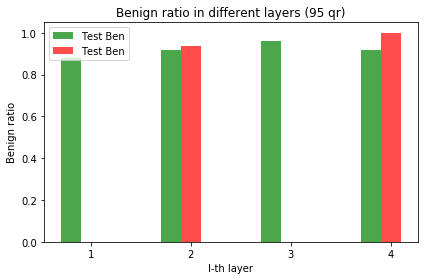

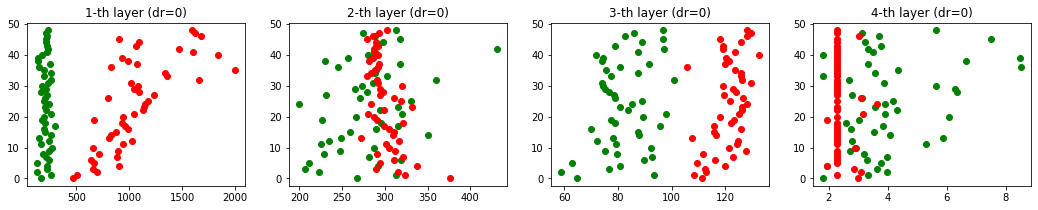

In [5]:
results = (prob_ALPs, prob_BLPs, A_LPs_score, B_LPs_score)
M.draw_rob_exp_results(results, 0, savefig=savefig)

In [7]:
'''
5. verify on robustied models  
'''
# dropout_rates = [0.01, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
dropout_rates = [0.01, 0.02]

for dropout_rate in dropout_rates:
    print('dropout_rate:', dropout_rate)
    
    # PI.generate_robustified_model('CNN', 15, dropout_rate)
    PI.generate_twisted_model('CNN', num_of_rob_train_eps, dropout_rate)
    results = M.robustify_by_dr(PI)
    M.draw_rob_exp_results(results, dropout_rate, savefig=savefig)

'\n3. Robustify model \n'